In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## A2/phi vs R - GADGET

In [2]:
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import barstrength as strng
import kapparot as krot
from matplotlib.font_manager import FontProperties

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

vector = ('00','01','03')
vector3 = ('M31','MW','M33')
vector2= ('blue', 'red', 'green')

j=0
snapshot=range(496,495,-1)
for isnap in snapshot:
    snap = h5py.File('/home/ornela/SimCLUES/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
    for i in range(0,2):
        cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value
        aexp = snap['subhalo_0'+ str('%s' %vector[i])+ '/Time'].value

        pstr = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
        masa_str = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_0'+ str('%s' %vector[i])+ '/Str/Velocities'].value

        pgas = snap['subhalo_0'+ str('%s' %vector[i])+ '/Gas/Coordinates'].value
        masa_gas = snap['subhalo_0'+ str('%s' %vector[i])+ '/Gas/Masses'].value

        pdrk = snap['subhalo_0'+ str('%s' %vector[i]) + '/Drk/Coordinates'].value
        masa_drk = snap['subhalo_0'+ str('%s' %vector[i])+ '/Drk/Masses'].value

        z = a0/aexp - 1.
        Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        
#---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0])*aexp/h
        ystr = (pstr[:,1]-cm[1])*aexp/h
        zstr = (pstr[:,2]-cm[2])*aexp/h
        r = np.sqrt(xstr**2+ystr**2+zstr**2)
        
        xgas = (pgas[:,0]-cm[0])*aexp/h
        ygas = (pgas[:,1]-cm[1])*aexp/h
        zgas = (pgas[:,2]-cm[2])*aexp/h
        rgas = np.sqrt(xgas**2+ygas**2+zgas**2)
        
        xdrk = (pdrk[:,0]-cm[0])*aexp/h
        ydrk = (pdrk[:,1]-cm[1])*aexp/h
        zdrk = (pdrk[:,2]-cm[2])*aexp/h
        rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
         
        v_x = vel[:,0] *np.sqrt(aexp) + Ht *xstr/1000.
        v_y = vel[:,1] *np.sqrt(aexp) + Ht *ystr/1000.
        v_z = vel[:,2] *np.sqrt(aexp) + Ht *zstr/1000.
        
#----------------------masas----------------------------
        masa_str = masa_str/h
        masa_gas = masa_gas/h
        masa_drk = masa_drk/h
        
        r200 = r200*aexp/h
        
        rgal=0.15*r200
        
        limit = np.where(r<rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])
        
        limit_gas = np.where(rgas<rgal)
        rgas_sort = np.sort(rgas[limit_gas])
        rgas_indice = np.argsort(rgas[limit_gas])
        
        Mc_str = cumsum((masa_str[limit])[r_indice])
        M_gal = Mc_str[-1]
        
        Mc_gas = cumsum((masa_gas[limit_gas])[rgas_indice])
        M_gas = Mc_gas[-1]
        
#------------------ calculamos M90------------------------------------------
        razon = Mc_str/M_gal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)
        
        r90 = r_sort[noventa]
        r50 = r_sort[cincuenta]
        M90 = Mc_str[noventa]                
             
#------------------masa total en r200 (Mvir)--------------------------
        rvir= concatenate([r,rgas,rdrk])
        mvir= concatenate([masa_str, masa_gas, masa_drk])
        
        limit_vir = np.where(rvir<r200)
        rvir_sort = np.sort(rvir[limit_vir])
        rvir_indice = np.argsort(rvir[limit_vir])
        
        Mc_vir = cumsum((mvir[limit_vir])[rvir_indice])
        
        M_vir = Mc_vir[-1]

#-------------------------------------------------------------------            
        corte1,=np.where(r<5)
        corte2,=np.where(r<2*r50[-1])
        veloc,=np.where(r<r50[-1])
        
#----------componentes de la velocidad del centro de masa------------
        vxcm = sum(masa_str[veloc]*v_x[veloc])/sum(masa_str[veloc])
        vycm = sum(masa_str[veloc]*v_y[veloc])/sum(masa_str[veloc])
        vzcm = sum(masa_str[veloc]*v_z[veloc])/sum(masa_str[veloc])
        
#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = vel[:,0] - vxcm
        vy = vel[:,1] - vycm
        vz = vel[:,2] - vzcm
        
        xn, yn, zn, vxn, vyn, vzn = rot.rot(masa_str, xstr, ystr, zstr, vx, vy, vz, r90[-1])
        
        A2max, rmax, phimax = strng.a2max(masa_str[corte1], xn[corte1], yn[corte1], 25)
        
        A2, phi, rbin = strng.a2(masa_str[corte1], xn[corte1], yn[corte1], 25)
        
        print 'phimax=', phimax
        
        phii = phi - phimax

        data = np.ndarray([np.size(A2),3])
        data[:,0] = rbin
        data[:,1] = A2
        data[:,2] = phii

        np.savetxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/'+str('%s'%vector3[i])+'_A2phivsR.dat', data, fmt='%12.6f')
    
    

phimax= 1.6740281549
phimax= -2.04528034243


## A2/phi vs R - GASOLINE

In [4]:
import h5py
import rotation as rot
import barstrength as strng

#Parámetros cosmológicos
#--------------------------------------------------------------------------
G = 4.299e-6
a0=1.
#---------------------------------------------------------------------------
vector =(1,2,4)
vector2=('M31','MW')

snapshot = np.loadtxt('/home/ornela/SimCLUES/Gasoline/snapshots.txt', dtype='string') #SNAPSHOTS
snapshot = snapshot[::-1]

for j in range(0,1):#len(snapshot)-1):
    
    snap = h5py.File('/home/ornela/SimCLUES/Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')
    
    for i in range(0,2):
        cm   = snap['subhalo_00'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_00'+ str('%s' %vector[i])+ '/R200'].value
        time = snap['subhalo_00'+ str('%s' %vector[i])+ '/Time'].value
        h    = snap['subhalo_00'+ str('%s' %vector[i])+ '/h'].value
        aexp = snap['subhalo_00'+ str('%s' %vector[i])+ '/aexp'].value

        pstr = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Coordinates'].value
        mstr = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Masses'].value
        vel  = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Velocities'].value

#paso las coordenadas al centro de la galaxia
        xstr = (pstr[:,0]-cm[0])
        ystr = (pstr[:,1]-cm[1])
        zstr = (pstr[:,2]-cm[2])
        r    = np.sqrt(xstr**2+ystr**2+zstr**2)
#----------------------------------------------------------------------

        rgal = 0.15*r200          #defino el radio de la galaxia

        limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
        r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
        r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

        Mc_str = cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
        Mgal = Mc_str[-1]  #masa total de la galaxia

    #Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
        razon = Mc_str/Mgal 
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)

        r90 = r_sort[noventa][-1]   #radio a 90% la masa
        r50 = r_sort[cincuenta][-1] #radio a 50% la masa
        
#-------------------------------------------------------------------------------
    #componentes de la velocidad del centro de masa
        veloc, = np.where(r < r50)

        vxcm = sum(mstr[veloc]*vel[:,0][veloc])/sum(mstr[veloc])
        vycm = sum(mstr[veloc]*vel[:,1][veloc])/sum(mstr[veloc])
        vzcm = sum(mstr[veloc]*vel[:,2][veloc])/sum(mstr[veloc])

    #velocidades de las estrellas respecto del centro de masa de la galaxia
        vx = vel[:,0] - vxcm
        vy = vel[:,1] - vycm
        vz = vel[:,2] - vzcm


    #hago la rotación de las coordenadas respecto del momento angular    
        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,r90)

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz

        corte3, = np.where(r<5)

        A2, phi, rbin = strng.a2(mstr[corte3], xn[corte3], yn[corte3], 10)
        A2max, rmax, phimax = strng.a2max(mstr[corte3], xn[corte3], yn[corte3], 20)
        
        print 'phimax=', phimax
        
        phii = phi - phimax

        data = np.ndarray([np.size(A2),3])
        data[:,0] = rbin
        data[:,1] = A2
        data[:,2] = phii

        np.savetxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gs/_data/'+str('%s'%vector2[i])+'_A2phivsR.dat', data, fmt='%12.6f')


phimax= 0.0203699439856
phimax= -1.47243510282


In [5]:
M31_gd = np.loadtxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/M31_A2phivsR.dat')
rn_M31gd  = M31_gd[:,0]
A2_M31gd  = M31_gd[:,1]
phi_M31gd = M31_gd[:,2]

for i in range(1,len(phi_M31gd)-1):
    if ((phi_M31gd[i]<np.arcsin(0.3)) & (phi_M31gd[i+1]>np.arcsin(0.3))):
        pend = (phi_M31gd[i+1]-phi_M31gd[i])/(rn_M31gd[i+1]-rn_M31gd[i])
        ordenada = phi_M31gd[i]- pend*rn_M31gd[i]
        lbar_M31gd = (np.arcsin(0.3) - ordenada)/pend
        break
    elif ((phi_M31gd[i]>-np.arcsin(0.3)) & (phi_M31gd[i+1]<-np.arcsin(0.3))):
        pend = (phi_M31gd[i+1]-phi_M31gd[i])/(rn_M31gd[i+1]-rn_M31gd[i])
        ordenada = phi_M31gd[i]- pend*rn_M31gd[i]
        lbar_M31gd = (-np.arcsin(0.3) - ordenada)/pend
        break
print 'lbar_M31gd=', lbar_M31gd

MW_gd = np.loadtxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/MW_A2phivsR.dat')
rn_MWgd  = MW_gd[:,0]
A2_MWgd  = MW_gd[:,1]
phi_MWgd = MW_gd[:,2]

for i in range(1,len(phi_MWgd)-1):
    if ((phi_MWgd[i]<np.arcsin(0.3)) & (phi_MWgd[i+1]>np.arcsin(0.3))):
        pend = (phi_MWgd[i+1]-phi_MWgd[i])/(rn_MWgd[i+1]-rn_MWgd[i])
        ordenada = phi_MWgd[i]- pend*rn_MWgd[i]
        lbar_MWgd = (np.arcsin(0.3) - ordenada)/pend
        break
    elif ((phi_MWgd[i]>-np.arcsin(0.3)) & (phi_MWgd[i+1]<-np.arcsin(0.3))):
        pend = (phi_MWgd[i+1]-phi_MWgd[i])/(rn_MWgd[i+1]-rn_MWgd[i])
        ordenada = phi_MWgd[i]- pend*rn_MWgd[i]
        lbar_MWgd = (-np.arcsin(0.3) - ordenada)/pend
        break
print 'lbar_MWgd=', lbar_MWgd

M31_gs = np.loadtxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gs/_data/M31_A2phivsR.dat')
rn_M31gs  = M31_gs[:,0]
A2_M31gs  = M31_gs[:,1]
phi_M31gs = M31_gs[:,2]

for i in range(1,len(phi_M31gs)-1):
    if ((phi_M31gs[i]<np.arcsin(0.3)) & (phi_M31gs[i+1]>np.arcsin(0.3))):
        pend = (phi_M31gs[i+1]-phi_M31gs[i])/(rn_M31gs[i+1]-rn_M31gs[i])
        ordenada = phi_M31gs[i]- pend*rn_M31gs[i]
        lbar_M31gs = (np.arcsin(0.3) - ordenada)/pend
        break
    elif ((phi_M31gs[i]>-np.arcsin(0.3)) & (phi_M31gs[i+1]<-np.arcsin(0.3))):
        pend = (phi_M31gs[i+1]-phi_M31gs[i])/(rn_M31gs[i+1]-rn_M31gs[i])
        ordenada = phi_M31gs[i]- pend*rn_M31gs[i]
        lbar_M31gs = (-np.arcsin(0.3) - ordenada)/pend
        break
print 'lbar_M31gs=', lbar_M31gs

MW_gs = np.loadtxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gs/_data/MW_A2phivsR.dat')
rn_MWgs  = MW_gs[:,0]
A2_MWgs  = MW_gs[:,1]
phi_MWgs = MW_gs[:,2]

for i in range(1,len(phi_MWgs)-1):
    if ((phi_MWgs[i]<np.arcsin(0.3)) & (phi_MWgs[i+1]>np.arcsin(0.3))):
        pend = (phi_MWgs[i+1]-phi_MWgs[i])/(rn_MWgs[i+1]-rn_MWgs[i])
        ordenada = phi_MWgs[i]- pend*rn_MWgs[i]
        lbar_MWgs = (np.arcsin(0.3) - ordenada)/pend
        break
    elif ((phi_MWgs[i]>-np.arcsin(0.3)) & (phi_MWgs[i+1]<-np.arcsin(0.3))):
        pend = (phi_MWgs[i+1]-phi_MWgs[i])/(rn_MWgs[i+1]-rn_MWgs[i])
        ordenada = phi_MWgs[i]- pend*rn_MWgs[i]
        lbar_MWgs = (-np.arcsin(0.3) - ordenada)/pend
        break
print 'lbar_MWgs=', lbar_MWgs

lbar_M31gd= 1.79498665931
lbar_MWgd= 2.29178963481
lbar_M31gs= 1.55609360328
lbar_MWgs= 2.50597298774


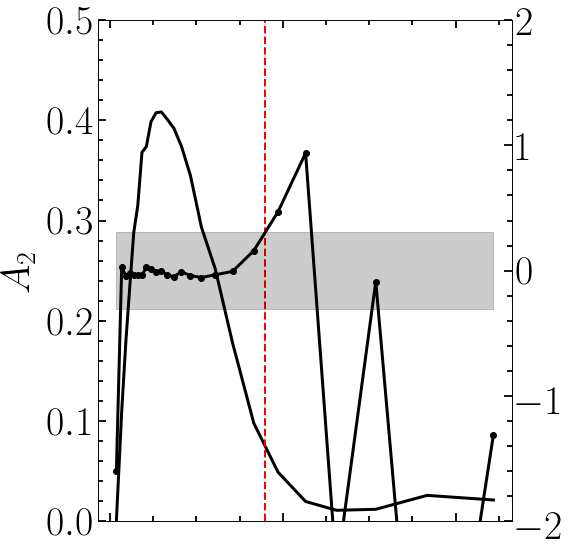

In [18]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

fig=plt.figure(1,figsize=(16,16))
fig.subplots_adjust(bottom=0.08, left =0.2, right = 0.92, top = 0.95, wspace=0., hspace= 0)



ax1=fig.add_subplot(221)

ax1.plot(rn_M31gd ,A2_M31gd,'-', lw=3, color='k')
ax1.set_xticklabels([])
ax1.set_ylabel(r'$A_{2}$', fontsize=40)
ax1.set_ylim(0,0.5)
ax1.set_xlim(0,5)
ax1.minorticks_on()
ax1.tick_params( labelsize=40)
ax1.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax1.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
ax1.axvline(x=lbar_M31gd, color='r', lw=2, ls='--')


ax01 = ax1.twinx()
ax01.plot(rn_M31gd,phi_M31gd,'o-', lw=3, color='k')
# ax01.set_yticklabels([])
ax01.set_ylim(-2,2)
ax01.minorticks_on()
ax01.tick_params( labelsize=40)
ax01.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax01.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
ax01.fill_between([rn_M31gd[0],rn_M31gd[-1]],np.arcsin(0.3),-np.arcsin(0.3), color='k', alpha=0.2, edgecolor=None)
# ax1.text(48, 185, 'GADGET-M31', fontsize=30, color='black', ha='right', va='center')



#------------------------------------------------------

# ax2=fig.add_subplot(222)
# ax2.plot(rtot_M31gs[np.where(Vtot_M31gs!=0)],Vtot_M31gs[np.where(Vtot_M31gs!=0)],'-', lw=3, color='k', label= 'Total')
# ax2.plot(rstr_M31gs[np.where(Vstr_M31gs!=0)],Vstr_M31gs[np.where(Vstr_M31gs!=0)],'-.',lw=3, color='r', label ='Stars')
# ax2.plot(rgas_M31gs[np.where(Vgas_M31gs!=0)],Vgas_M31gs[np.where(Vgas_M31gs!=0)],':', color ='b',lw=3, label='Gas')
# ax2.plot(rdrk_M31gs[np.where(Vdrk_M31gs!=0)],Vdrk_M31gs[np.where(Vdrk_M31gs!=0)],'--',color='g', lw=3, label='Dark Matter')

# ax2.text(48, 185, 'GASOLINE-M31', fontsize=30, color='black', ha='right', va='center')
# #plt.legend(handles=[total,stars,gas,drk],fontsize=18, frameon=False)
# ax2.set_xticklabels([])
# ax2.set_yticklabels([])
# # ax2.set_ylim(0,200)
# ax2.set_xlim(0,5)
# ax2.minorticks_on()
# ax2.tick_params( labelsize=40)
# ax2.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
# ax2.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')


# #---------------------------------------------------------

# ax3=fig.add_subplot(223)
# ax3.plot(rtot_MWgd[np.where(Vtot_MWgd!=0)],Vtot_MWgd[np.where(Vtot_MWgd!=0)],'-', lw=3, color='k', label= 'Total')
# ax3.plot(rstr_MWgd[np.where(Vstr_MWgd!=0)],Vstr_MWgd[np.where(Vstr_MWgd!=0)],'-.',lw=3, color='r', label ='Stars')
# ax3.plot(rgas_MWgd[np.where(Vgas_MWgd!=0)],Vgas_MWgd[np.where(Vgas_MWgd!=0)],':', color ='b',lw=3, label='Gas')
# ax3.plot(rdrk_MWgd[np.where(Vdrk_MWgd!=0)],Vdrk_MWgd[np.where(Vdrk_MWgd!=0)],'--',color='g', lw=3, label='Dark Matter')

# ax3.text(48, 185, 'GADGET-MW', fontsize=30, color='black', ha='right', va='center')
# #plt.legend(handles=[total,stars,gas,drk],fontsize=18, frameon=False)
# ax3.set_xlabel(r'$r\:[kpc]$', fontsize=40)
# ax3.set_ylabel(r'$V_{c}\:[km\:s^{-1}]$', fontsize=40)
# # ax3.set_ylim(0,200)
# ax3.set_xlim(0,5)
# ax3.minorticks_on()
# ax3.tick_params( labelsize=40)
# ax3.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
# ax3.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')


# #---------------------------------------------------------------------------------------
# ax4=fig.add_subplot(224)
# ax4.plot(rtot_MWgs[np.where(Vtot_MWgs!=0)],Vtot_MWgs[np.where(Vtot_MWgs!=0)],'-', lw=3, color='k', label= 'Total')
# ax4.plot(rstr_MWgs[np.where(Vstr_MWgs!=0)],Vstr_MWgs[np.where(Vstr_MWgs!=0)],'-.',lw=3, color='r', label ='Stars')
# ax4.plot(rgas_MWgs[np.where(Vgas_MWgs!=0)],Vgas_MWgs[np.where(Vgas_MWgs!=0)],':', color ='b',lw=3, label='Gas')
# ax4.plot(rdrk_MWgs[np.where(Vdrk_MWgs!=0)],Vdrk_MWgs[np.where(Vdrk_MWgs!=0)],'--',color='g', lw=3, label='Dark Matter')

# ax4.text(48, 185, 'GASOLINE-MW', fontsize=30, color='black', ha='right', va='center')
# #plt.legend(handles=[total,stars,gas,drk],fontsize=18, frameon=False)
# ax4.set_xlabel(r'$r\:[kpc]$',fontsize=40)
# ax4.set_yticklabels([])
# # ax4.set_ylim(0,200)
# ax4.set_xlim(0,5)
# ax4.minorticks_on()
# ax4.tick_params( labelsize=40)
# ax4.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
# ax4.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')

# fig.savefig('/home/ornela/Dropbox/Presentacion_graficos/A2_phi_vsR.png', dpi = 100, xxbox_inches='tight')
# #fig.savefig('/home/ornela/Escritorio/mi_tesis/Figures/GD_'+str('%s'%vector4[i])+'-Vc.png', dpi = 100)
# #fig.savefig('/home/ornela/Escritorio/presentacion_final/GD_'+str('%s'%vector4[i])+'-Vc.png', dpi = 100)
# plt.show()


In [ ]:
ax.fill_between([rbin[0]-0.5,rbin[-1]+0.5],np.arcsin(0.3),-np.arcsin(0.3), color='silver')